## 1. Import Important **Libraries**

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input/dogs-vs-cats/"))

Using TensorFlow backend.


['sampleSubmission.csv', 'test1.zip', 'train.zip']


## 2. Define Image PROPERTIES

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# channel refer to number of colors, here RGB
IMAGE_CHANNELS=3

## 3. Prepare dataset for training model:

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r')
zip_ref.extractall('/tmp/train')
zip_ref.close()


In [5]:
filenames = os.listdir("/tmp/train/train")
# we are definig empty list categories
# it will contain 0 or 1 as per the image
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

# creating a dataframe conataining columns of image-name and (0/1) according to type of image
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [6]:
df.head()

,filename,category
0,dog.890.jpg,1
1,dog.1178.jpg,1
2,dog.7845.jpg,1
3,dog.4632.jpg,1
4,cat.3660.jpg,0


In [7]:
df.tail()

,filename,category
24995,dog.6505.jpg,1
24996,cat.3805.jpg,0
24997,cat.5513.jpg,0
24998,cat.6808.jpg,0
24999,dog.7780.jpg,1


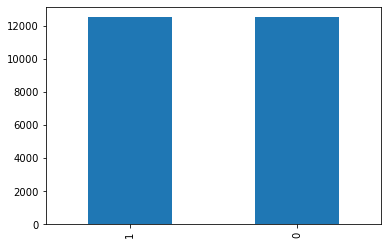

In [8]:
# now lets look at total number of dog and cat present 
df['category'].value_counts().plot.bar()

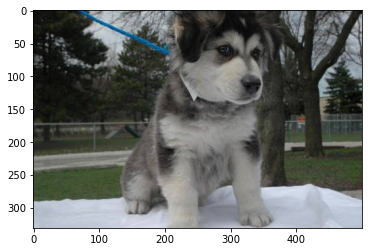

In [9]:
# looking as a sample image
sample = random.choice(filenames)
image = load_img("/tmp/train/train/"+sample)
plt.imshow(image)

## 4. Creating a neural network model

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

# Keras defines a sequential model as a sequential stack of linear layers.
model=Sequential()

# here we using 32 filter layers and kernel size of (3,3), with relu activation function (max(0,x))
# Batch normalization() is a technique for improving the speed, performance, and stability of cnn.
# max pooling reduces the dimensionality of images by reducing the number of pixels in the output from previous cnn
# pool size define size of filter
# Droupout drops out the nodes from the layer and reduce chances of overfitting

#1st layer is input layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd layer
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd layer
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten convert matrix into single array
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Finally we compile our model with rsmprop optimizer
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

## 5. Analyzing model 

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

## 6. Define callbacks and learning rate:
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

You define and use a callback when you want to automate some tasks after every training/epoch that help you have controls over the training process. This includes stopping training when you reach a certain accuracy/loss score, saving your model as a checkpoint after each successful epoch, adjusting the learning rates over time, and more. Let’s dive deep into some callback functions!

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#One way to avoid overfitting is to terminate the process early using earlystop
earlystop = EarlyStopping(patience = 10)

# Following line will reduce learning rate when a metric has stopped improving. 
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]


## 7. Manage DATA
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [13]:
# replacing category with their name
df["category"] = df["category"].replace({0:'cat',1:'dog'})

#using train_test_split to split your data
train_df,validate_df = train_test_split(df,test_size=0.20,random_state=42)

#resetting the index
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]

# batch_size specifies how many training samples should be sent to the model at once.
batch_size=15

## 8. Training Generator

In [14]:
# we create multiple image from one image for good efficiency 
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/tmp/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation Generator

In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/tmp/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## Testing the working of our generators

In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/tmp/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


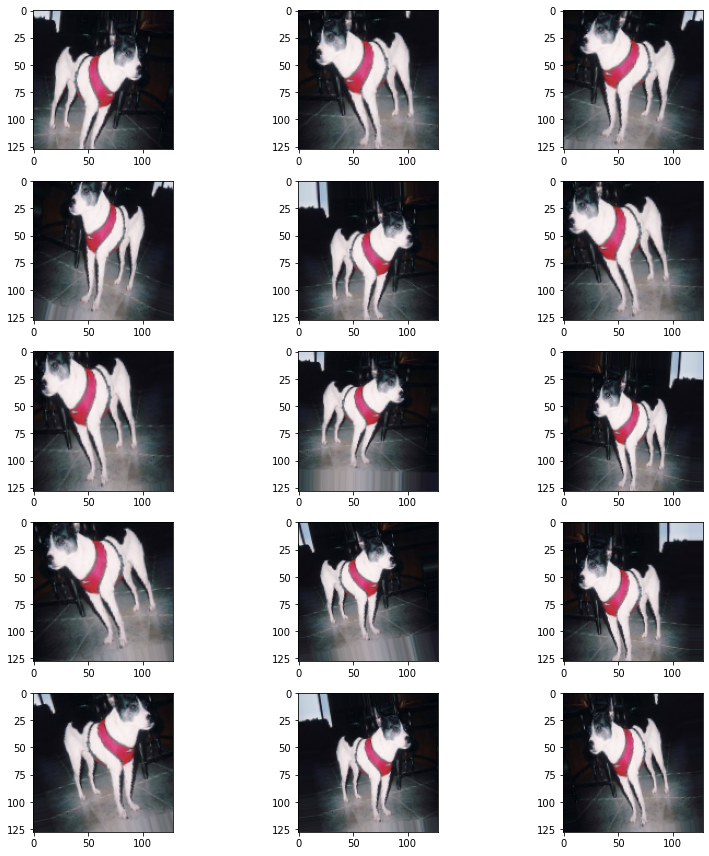

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 9. Training Model

In [18]:
# instead of 5 use 50 for bests results
epochs=3 if FAST_RUN else 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/5
1333/1333 [==============================] - 260s 195ms/step - loss: 0.7509 - accuracy: 0.6423 - val_loss: 0.8378 - val_accuracy: 0.7399
Epoch 2/5
   1/1333 [..............................] - ETA: 29s - loss: 0.9870 - accuracy: 0.5333

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 246s 184ms/step - loss: 0.5600 - accuracy: 0.7207 - val_loss: 0.2804 - val_accuracy: 0.7517
Epoch 3/5
1333/1333 [==============================] - 241s 181ms/step - loss: 0.5084 - accuracy: 0.7557 - val_loss: 0.2879 - val_accuracy: 0.7962
Epoch 4/5
1333/1333 [==============================] - 239s 179ms/step - loss: 0.4701 - accuracy: 0.7810 - val_loss: 0.3076 - val_accuracy: 0.8387
Epoch 5/5
1333/1333 [==============================] - 243s 182ms/step - loss: 0.4377 - accuracy: 0.8021 - val_loss: 0.5356 - val_accuracy: 0.7009


## 10. Save Model

In [ ]:
model.save_weights("model.h5")
model.save("model1_catsVSdogs_10epoch.h5")

## 11. Prepare Testing Data

In [20]:
import zipfile
zip_ref = zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r')
zip_ref.extractall('/tmp/test1')
zip_ref.close()


In [21]:
test_filenames = os.listdir("/tmp/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## 12. Create Testing Generator

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/tmp/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=15,
    shuffle=False
)

Found 12500 validated image filenames.


## 13. Predict

In [24]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [25]:
test_df['category'] = np.argmax(predict, axis=-1)

## 14. See Predicted Result

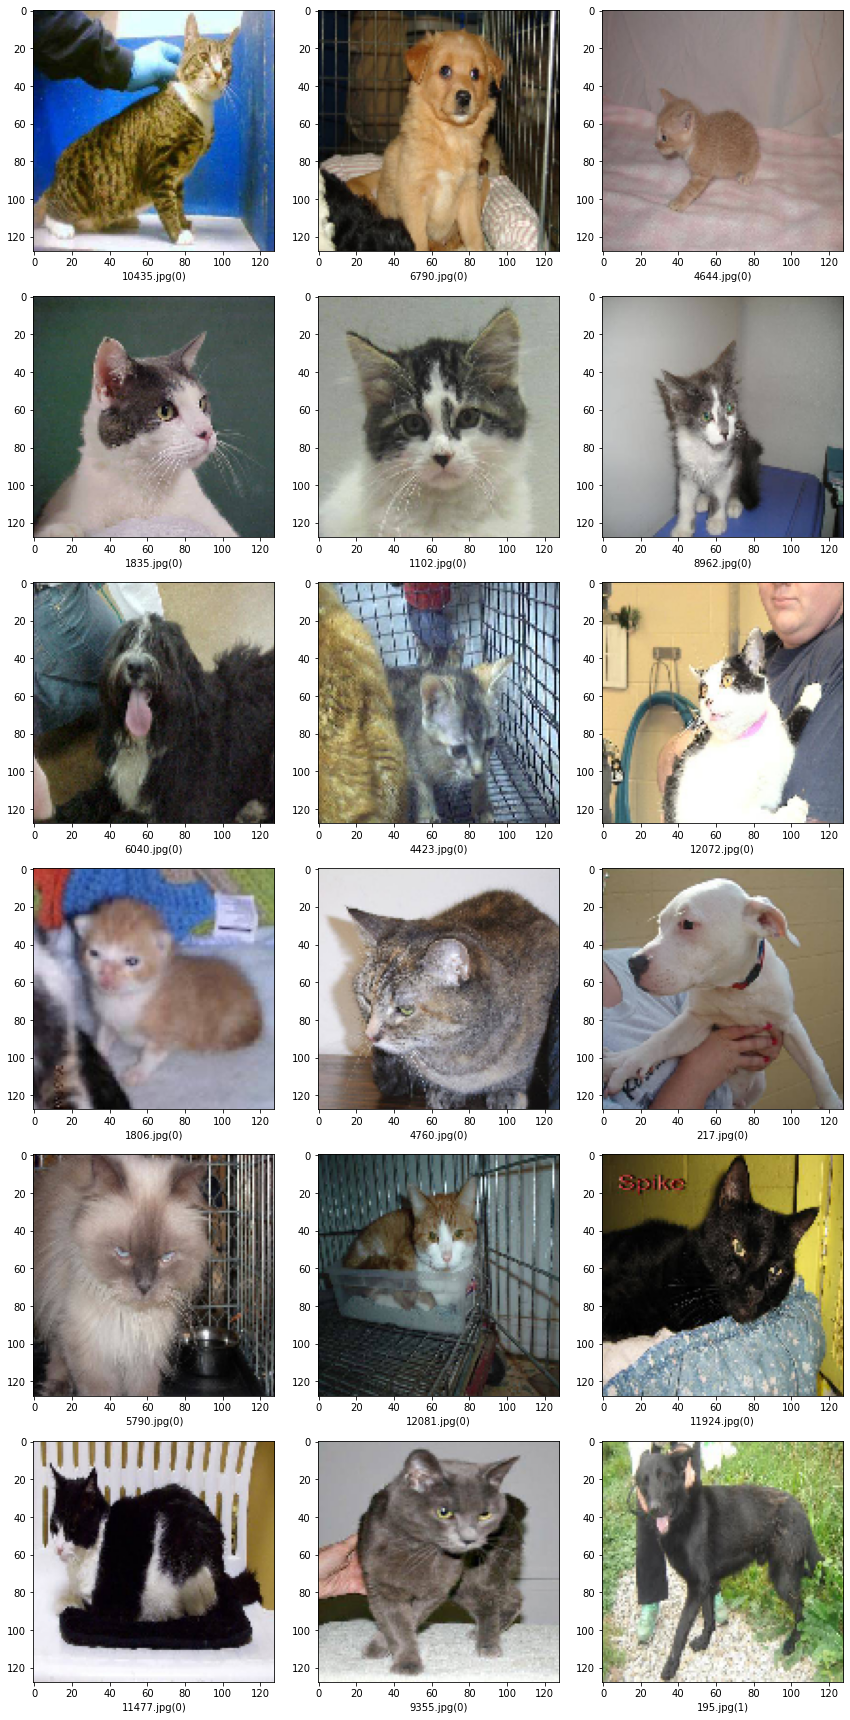

In [26]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/tmp/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## 15. Submission

In [27]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

## END